# The SSR Under QR Heston

We compute the SSR under quadratic rough Heston by blipping.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

from fwd_var_curve import xi_curve_smooth
from qrheston import QuadraticRoughHeston
from utils import black_otm_impvol_mc, var_swap_robust

sns.set_context("notebook")

%config InlineBackend.figure_format='retina'

# Gamma kernel

The gamma kernel is given by $$ \kappa(\tau)= \frac{\nu}{\Gamma(\alpha)} \, \tau^{\alpha-1}\,e^{-\lambda \tau}, $$

with $\alpha = H + \tfrac12$.


In [2]:
params0 = {"al": 0.568, "lam": 9.68, "nu": 0.572, "c": 8.1e-3}

# Initial forward variance curve $\xi_t(u)$


In [3]:
df_spx = pd.read_csv("spx_implied_vol_20230215.csv", index_col=0)
res_vs = var_swap_robust(ivol_data=df_spx)
w_in = res_vs["vs_mid"] * res_vs["expiries"]
xi_smooth = xi_curve_smooth(res_vs["expiries"], w_in, eps=0.03)["xi_curve"]

/Users/florianbourgey/projects/gatheral/QuadraticRoughHeston/Python/utils.py:156: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  wbar_flat = quad(PchipInterpolator(np.sort(y_in), sig_in_y**2), y_min, y_max)[0]


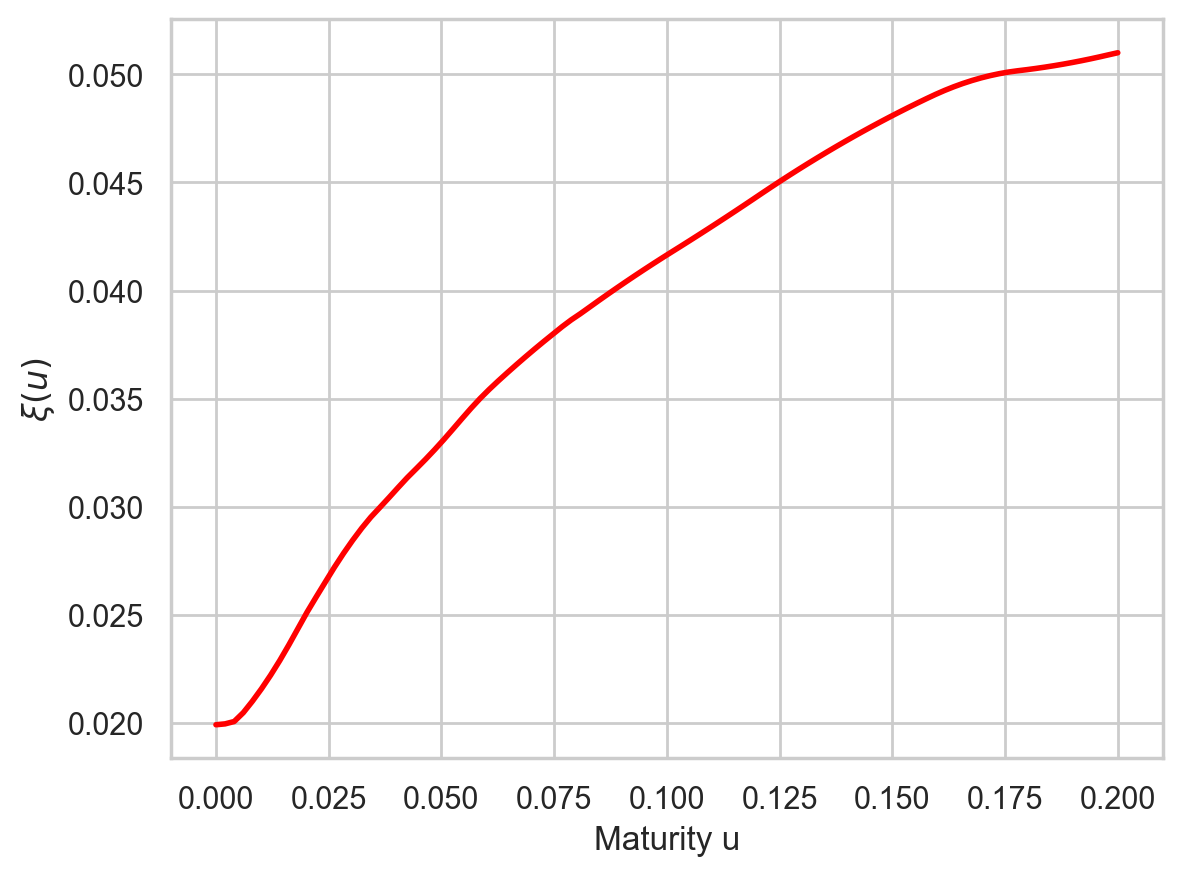

In [4]:
u = np.linspace(0, 0.2, 100)
fig, ax = plt.subplots()
ax.plot(u, xi_smooth(u), color="red", linewidth=2)
ax.set_xlabel("Maturity u")
ax.set_ylabel(r"$\xi(u)$")
plt.show()

# $y_t(u)$ from $\xi_t(u)$

$$ y_t(u)^2= \xi_t(u) - c - \int_t^u\,\xi_t(s)\,\kappa (u-s)^2\,ds. $$


Integration is performed using Gauss-Jacobi quadrature.


In [5]:
qrh = QuadraticRoughHeston(**params0, xi0=xi_smooth)

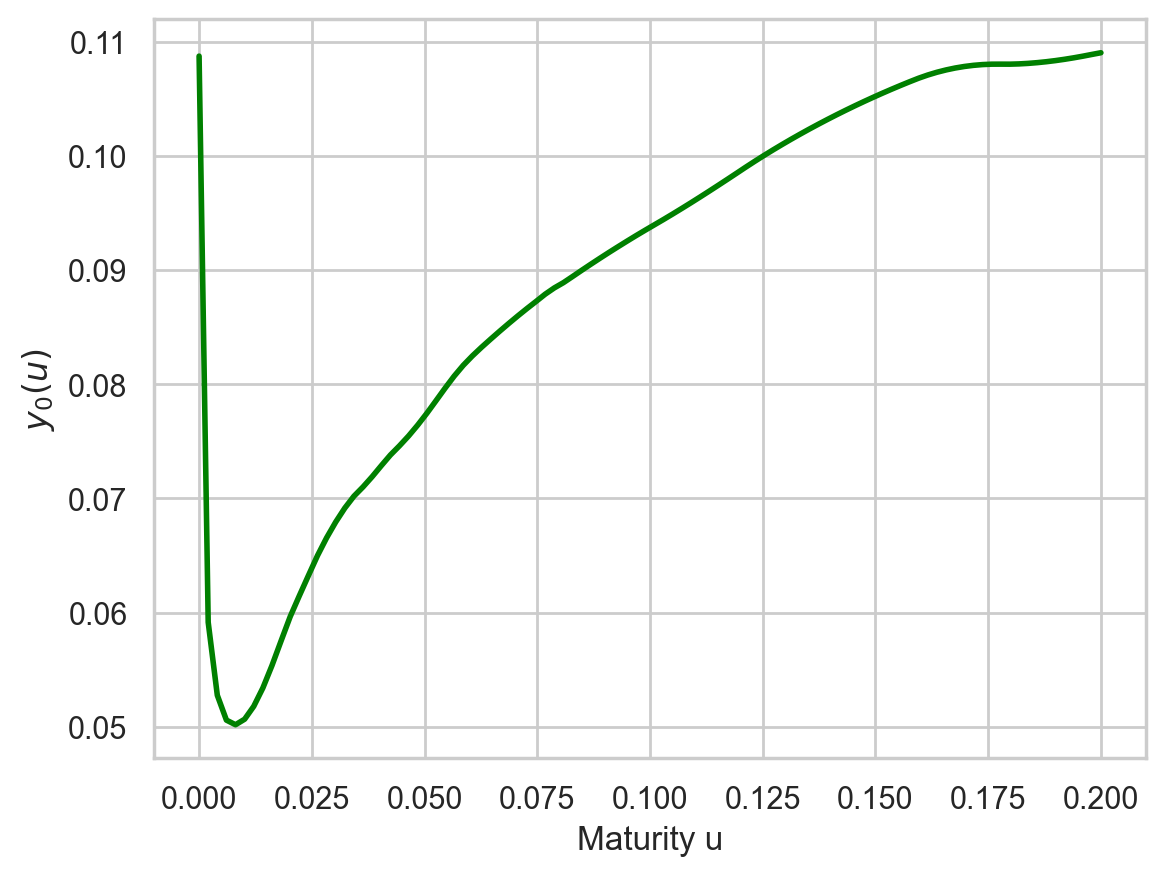

In [6]:
u = np.linspace(0, 0.2, 100)
fig, ax = plt.subplots()
ax.plot(u, qrh.y0(u), color="g", linewidth=2)
ax.set_xlabel("Maturity u")
ax.set_ylabel(r"$y_0(u)$")
plt.show()

# The SSR under quadratic rough Heston

Recall that in forward volatility form, the QR Heston model reads:

$$ dy_t(u) = \kappa(u-t)\,\sqrt{V_t}\,dW_t. $$

We may then apply the finite difference methodology of [Bourgey et al.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4911186) to approximate the SSR. Specifically, the regression coefficient is given by

$$ \beta_{t}(T) \approx \frac{1}{h} \, {\sigma_{t} \left(T,y^h_{t}(\cdot)\right) - \sigma_{t}\left(T, y_{t}(\cdot)\right)}, $$

where $h$ is a small parameter and for $t \leq u \leq T$, $$ y^h_{t}(u) := y_t(u) - h\,\kappa(u-t), $$

where we have used that the spot-vol correlation is $-1$.

The SSR is then estimated as $$ \mathcal{R}_{t}(T) \approx \frac{\beta_t(T)}{\mathcal{S}_t(T)}, $$ where $\mathcal{S}_t(T)$ is the ATM skew.


# Blipped forward volatility curves


Experiment shows that scaling the blip by time to expiration works well.

Specifically, we choose $h=-0.01 \sqrt{T}$.

$h<0$ ensures a positive blipped forward variance curve.


In [33]:
paths = 1 * 10**5
steps = 100

# paths = 3 * 10**5
# steps = 300

In [34]:
expiries = 2 ** (np.arange(-13, 1) / 2)
n_expiries = expiries.shape[0]

In [35]:
def h_ssr(t):
    return -1e-2 * np.sqrt(t)

In [36]:
res = qrh.simulate(
    paths=paths, steps=steps, expiries=expiries, output="spx", h_ssr=h_ssr
)

# Compute base and blipped implied volatilities


First we construct a matrix of $S_T$ values from the output of `QRH.blip`.


In [37]:
S_matrix = np.array([np.exp(res[T]["X"]) for T in expiries])
S_h_matrix = np.array([np.exp(res[T]["X_h"]) for T in expiries])

# Illustrate for one expiration


In [38]:
k = np.arange(-0.4, 0.2, 0.001)
idx = 8
impvols_mc = black_otm_impvol_mc(S_matrix[idx, :], k=k, T=expiries[idx])
impvols_h_mc = black_otm_impvol_mc(S_h_matrix[idx, :], k=k, T=expiries[idx])

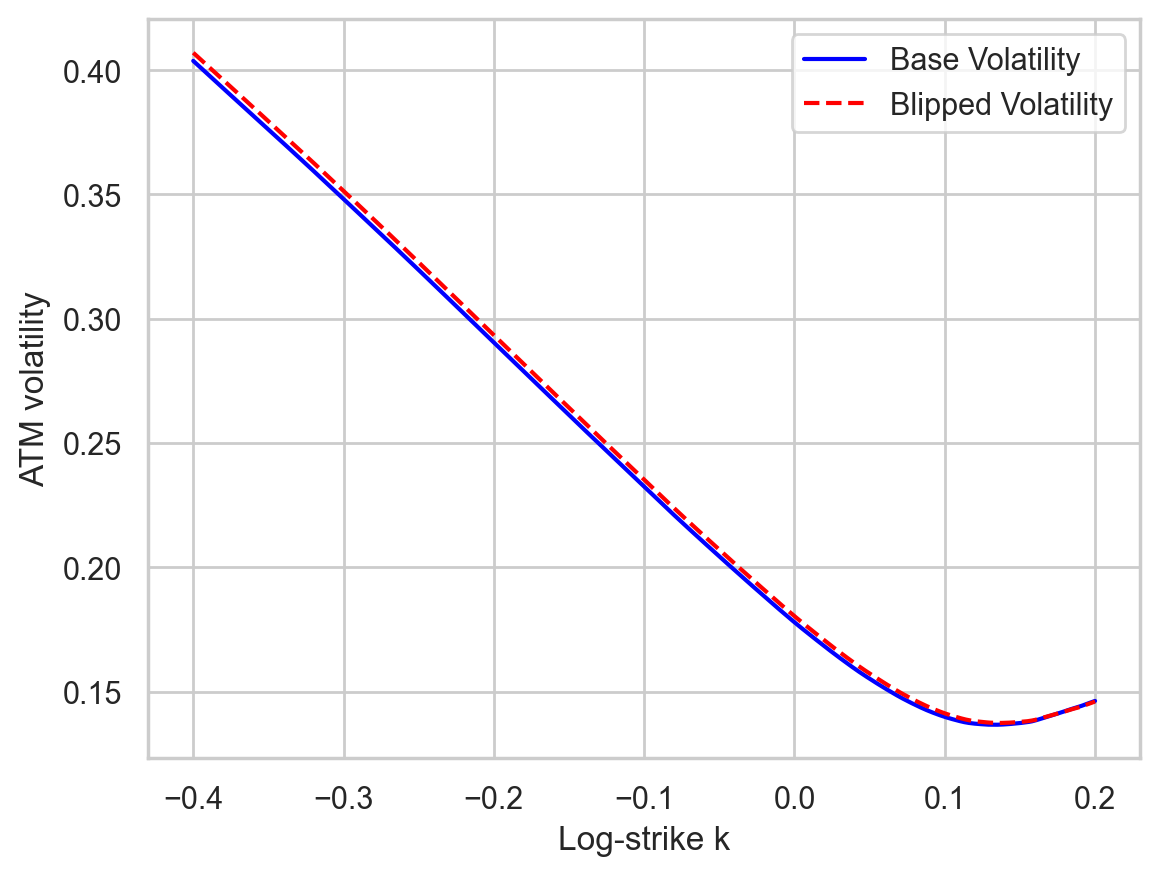

In [39]:
fig, ax = plt.subplots()
ax.plot(k, impvols_mc, color="blue", linestyle="-", label="Base Volatility")
ax.plot(k, impvols_h_mc, color="red", linestyle="--", label="Blipped Volatility")
ax.set_xlabel("Log-strike k")
ax.set_ylabel("ATM volatility")
ax.legend()
plt.show()

# Computation of the regression coefficient $\beta$


In [40]:
atm_impvols_mc = np.array(
    [
        black_otm_impvol_mc(S_matrix[idx, :], k=0.0, T=expiries[idx])
        for idx in range(n_expiries)
    ]
).flatten()
atm_impvols_h_mc = np.array(
    [
        black_otm_impvol_mc(S_h_matrix[idx, :], k=0.0, T=expiries[idx])
        for idx in range(n_expiries)
    ]
).flatten()
beta = (atm_impvols_h_mc - atm_impvols_mc) / h_ssr(expiries)

In [41]:
h_ssr(expiries)

array([-0.00105112, -0.00125   , -0.00148651, -0.00176777, -0.00210224,
       -0.0025    , -0.00297302, -0.00353553, -0.00420448, -0.005     ,
       -0.00594604, -0.00707107, -0.00840896, -0.01      ])

# Log-log plot of $\beta_t(T)$


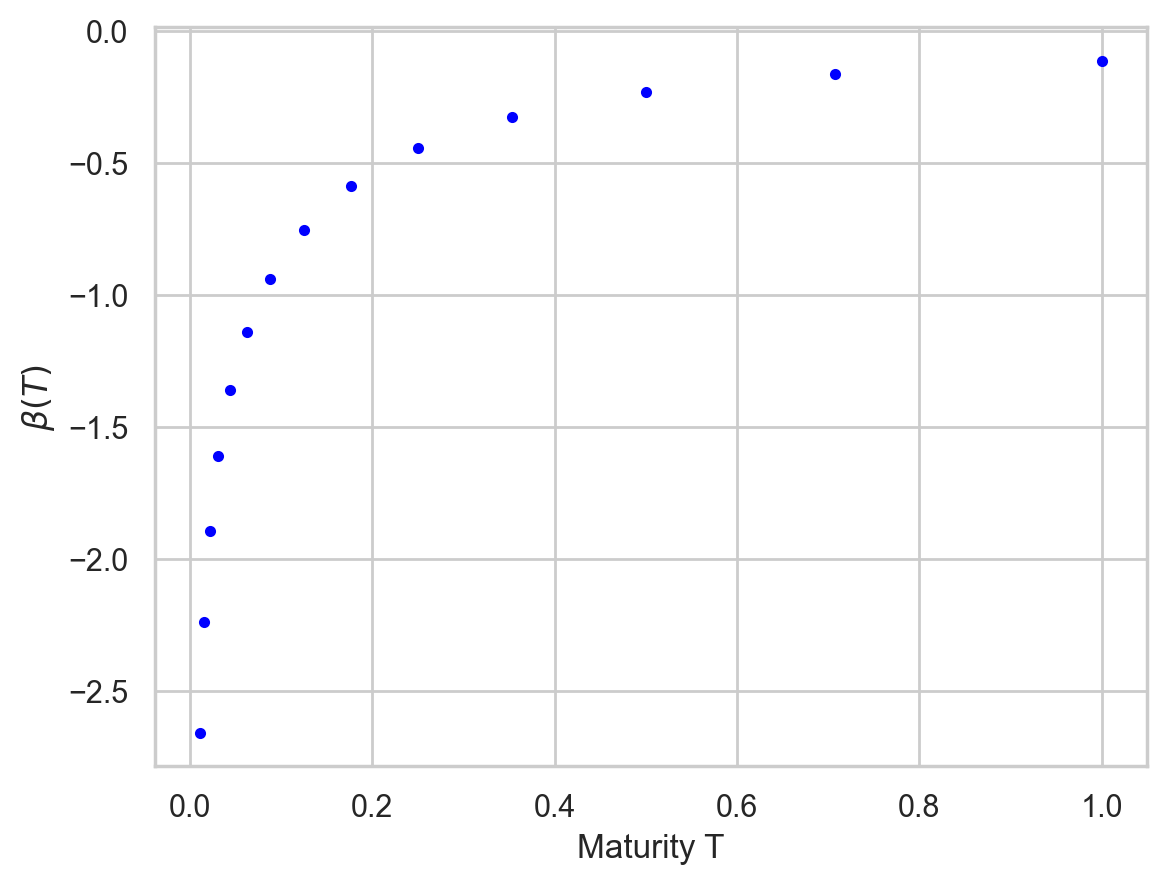

In [42]:
fig, ax = plt.subplots()
ax.plot(expiries, beta, ".b")
ax.set_xlabel("Maturity T")
ax.set_ylabel(r"$\beta(T)$")
plt.show()

# Skew computation


We can estimate the ATM skew $\mathcal{S}(\tau) = \left. \frac{\partial \sigma_{\text{BS}}(k,T)}{\partial k}\right|_{k=0}$ by Monte Carlo using the following implied volatility skew representation, $$ \frac{\partial \sigma_{\text{BS}}(k,T)}{\partial k} = \left. \frac{\Phi\left(-\frac{k}{\sqrt{w}} - \frac{\sqrt{w}}{2}\right) - \mathbb P\left(X_T \geq k\right)}{\sqrt{T} \phi\left(-\frac{k}{\sqrt{w}} - \frac{\sqrt{w}}{2}\right)} \right|_{w=T \sigma_{\text{BS}}^2(k,T)} $$ where $\phi$ is the PDF of a standard normal distribution.


In [43]:
w = expiries * atm_impvols_mc**2
atm_digit = (S_matrix >= S_matrix.mean(axis=1, keepdims=True)).mean(axis=1)
atm_skew = norm.cdf(-0.5 * w**0.5) - atm_digit
atm_skew /= expiries**0.5 * norm.pdf(-0.5 * w**0.5)

In [44]:
atm_digit

array([0.5577 , 0.55844, 0.56049, 0.56413, 0.56789, 0.57077, 0.57223,
       0.57211, 0.5695 , 0.5639 , 0.55448, 0.54164, 0.52659, 0.50903])

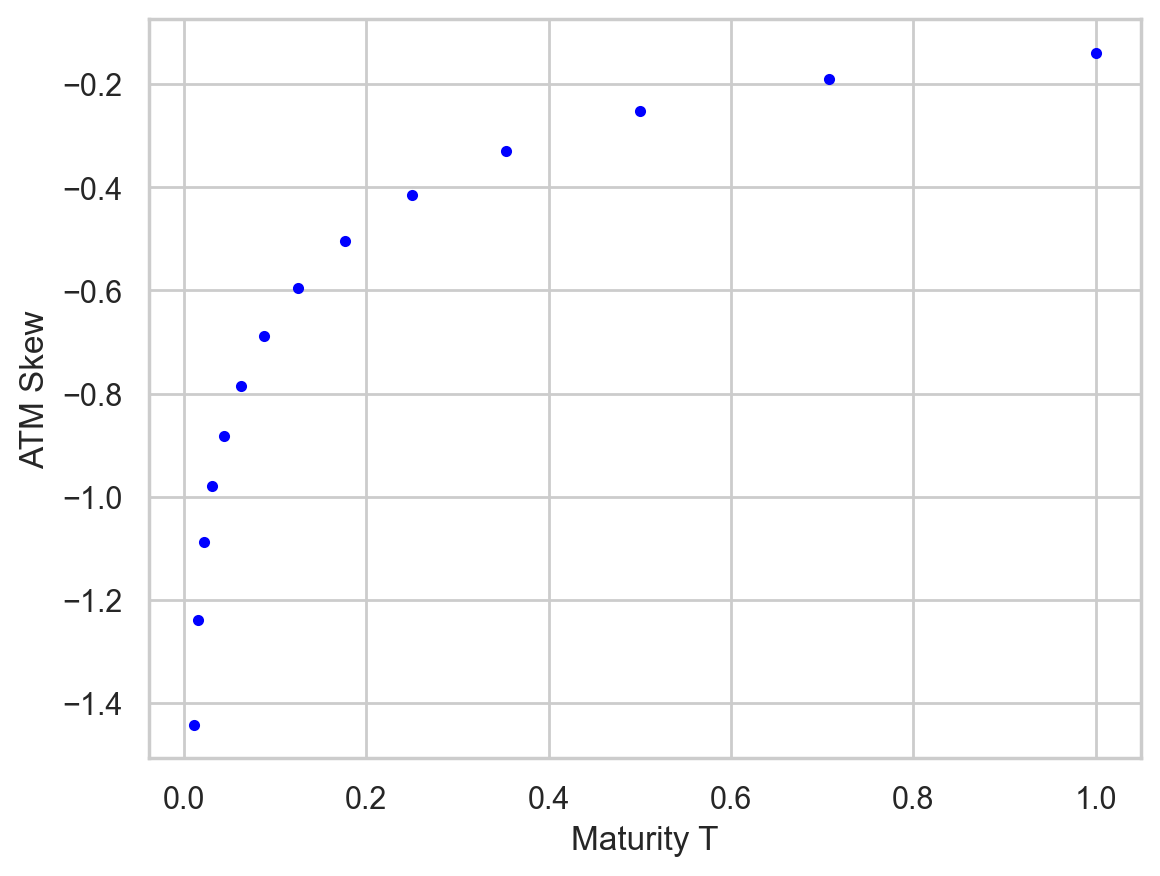

In [45]:
fig, ax = plt.subplots()
ax.plot(expiries, atm_skew, ".b")
ax.set_xlabel("Maturity T")
ax.set_ylabel("ATM Skew")
plt.show()

# Log-log plot of $\mathcal{S}_t(T)$


In [46]:
ssr = beta / atm_skew
ssr

array([1.84370635, 1.80755093, 1.7419303 , 1.64416048, 1.54451324,
       1.45265635, 1.36430207, 1.26705799, 1.16681016, 1.07089638,
       0.99222279, 0.92833302, 0.8661724 , 0.82195173])

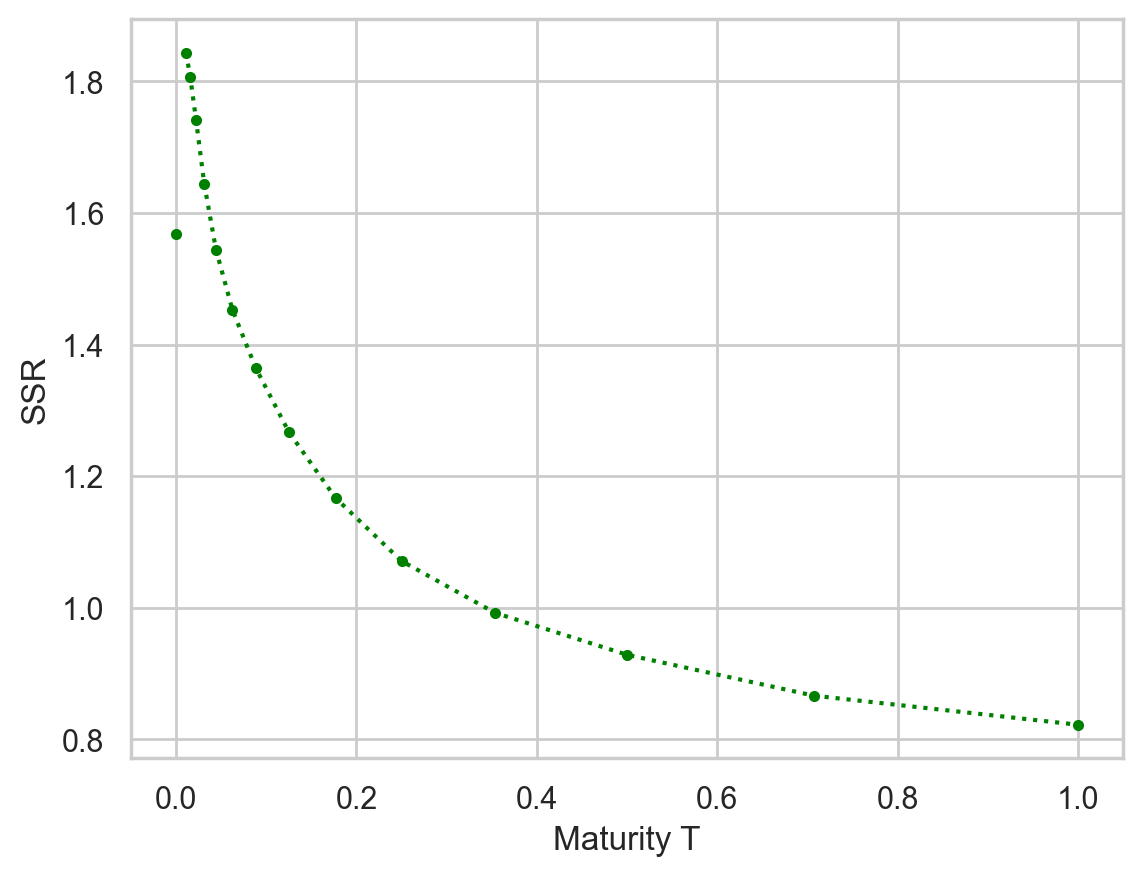

In [47]:
fig, ax = plt.subplots()
ax.plot(expiries, ssr, ".:g")
ax.plot([0], [qrh.H + 1.5], ".:g")
ax.set_xlabel("Maturity T")
ax.set_ylabel("SSR")
plt.show()